In [187]:
## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2.12.0


In [2]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

### Cargar imágenes

In [3]:
### Rutas de todas las imágenes

## Obtener todas las rutas de las imágenes en el dataset
ruta_dataset  = glob.glob('/home/willy98/archivos/Datasets/SH_procesadas/Recortadas_grises/*/*/*/*.jpg')

## Capturar solo rutas secas 
rutas_imagenes_secas = []
rutas_imagenes_humedas = []

clases_secas= []
clases_humedas = []
for ruta in ruta_dataset:
    if ruta.split('/')[-2] == 'Secas' or ruta.split('/')[-2] == 'Seca':
        clases_secas.append(ruta.split('/')[-4])
        rutas_imagenes_secas.append(ruta)
    else:
        clases_humedas.append(ruta.split('/')[-4])
        rutas_imagenes_humedas.append(ruta)

## Construcción de datasets
data_secas = pd.DataFrame({'ruta':rutas_imagenes_secas,'clase':clases_secas})
data_humedas = pd.DataFrame({'ruta':rutas_imagenes_humedas,'clase':clases_humedas})

## reemplazo de etiquetas}
lables_generalization = {'CuNi1':'MF1','CuNi2':'MF2','CuNi3':'MF3'}
data_secas.replace(lables_generalization,inplace=True)
data_humedas.replace(lables_generalization,inplace=True)

## summary    
print('Imágenes secas:', np.shape(rutas_imagenes_secas)[0],' - Imágenes Húmedas: ',np.shape(rutas_imagenes_humedas)[0])
print('MF1:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF1'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF2'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(data_secas[data_secas['clase']=='MF3'])[0], '- húmedas: ', np.shape(data_humedas[data_humedas['clase']=='MF3'])[0])

Imágenes secas: 931  - Imágenes Húmedas:  792
MF1: - secas:  379 - húmedas:  265
MF2: - secas:  289 - húmedas:  265
MF3: - secas:  263 - húmedas:  262


### Data Augmentation (Secas)

In [4]:
## Crear Dataframe
df_secas = pd.DataFrame()
df_secas['routes'] = rutas_imagenes_secas
df_secas['label'] = clases_secas

char_to_num = {'CuNi1':'0','CuNi2':'1','CuNi3':'2'}

df_secas['label'].replace(char_to_num,inplace=True)

## Recolver dataframe
df_secas = df_secas.sample(frac=1,random_state=42).reset_index(drop=True)

In [5]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='0'])))
thold2 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='1'])))
thold3 = int(np.ceil(0.8 * len(df_secas[df_secas.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = df_secas[df_secas.label == '0'][0:thold1]
train_cu2 = df_secas[df_secas.label == '1'][0:thold2]
train_cu3 = df_secas[df_secas.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = df_secas[df_secas.label == '0'][thold1:]
test_cu2 = df_secas[df_secas.label == '1'][thold2:]
test_cu3 = df_secas[df_secas.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  304 , test:  75
Clase MF2: train:  232 , test:  57
Clase MF3: train:  211 , test:  52


In [6]:
## Crear objetos transformadores
## Para entrenamiento
img_generator_training = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator= img_generator_training.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="routes",
    y_col="label",
    labels = ['MF1','MF2','MF3'],
    subset="training",
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

Found 598 validated image filenames belonging to 3 classes.


In [7]:
X_train_secas_expanded = []
y_train_secas_expanded = []

batches = 50
cnt = 0

for i in range(batches):
    
    x,y = train_generator.next()

    X_train_secas_expanded.extend(x)
    y_train_secas_expanded.extend(y)
    
print(np.shape(X_train_secas_expanded),np.shape(y_train_secas_expanded))

(2990, 128, 128, 1) (2990,)


(128, 128, 1)
0.007843138 0.882353


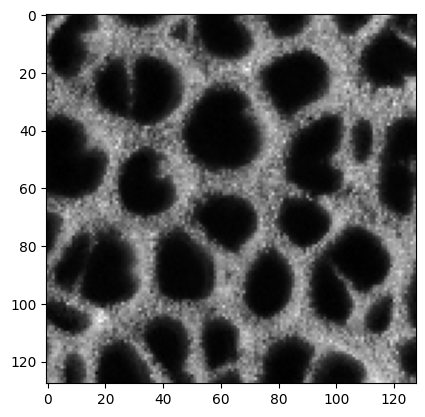

In [8]:
plt.imshow(X_train_secas_expanded[0],cmap='gray')
print(np.shape(X_train_secas_expanded[0]))
print(np.min(X_train_secas_expanded[0]),np.max(X_train_secas_expanded[0]))
plt.show()

In [9]:
## Dataset de prueba
test_df = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_secas = []
y_test_secas = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df)):
    
    #Capturar ruta y label
    ruta = test_df.iloc[i].routes
    label = test_df.iloc[i].label
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta,color_mode='grayscale')
    
    X_test_secas.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_secas.append(test_df.iloc[i].label)
    
print('Test: train->',np.shape(X_test_secas),' test ->',np.shape(y_test_secas))

Test: train-> (184, 128, 128, 1)  test -> (184,)


In [10]:
x_train_secas_expanded = np.array(X_train_secas_expanded)
x_test_secas = np.array(X_test_secas)

x_train_secas_expanded = x_train_secas_expanded.astype('float32')
x_test_secas= x_test_secas.astype('float32')
 
y_test_secas = tf.keras.utils.to_categorical(y_test_secas)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_secas /= 255

print('x_train shape:', x_train_secas_expanded.shape)
print('Number of images in x_train', x_train_secas_expanded.shape[0], "y_train:", np.shape(y_train_secas_expanded))
print('Number of images in x_test', x_test_secas.shape, "y_test: ", np.shape(y_test_secas))

x_train shape: (2990, 128, 128, 1)
Number of images in x_train 2990 y_train: (2990,)
Number of images in x_test (184, 128, 128, 1) y_test:  (184, 3)


### Cargar modelo

In [11]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
encoder = keras.models.load_model('models/GVAE_encoder_DA_dry_1_128.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('models/GVAE_decoder_DA_dry_1_128.h5', custom_objects={'Sampling':Sampling})

2023-08-29 23:57:50.092015: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10696 MB memory:  -> device: 0, name: NVIDIA TITAN V, pci bus id: 0000:1c:00.0, compute capability: 7.0


## Reconstrucción

In [13]:
tipo = 'secas'
if tipo == 'secas': 
    print('Dataset secas')
    data_train = x_train_secas_expanded
    data_test = x_test_secas

    label_train = y_train_secas_expanded
    label_test = y_test_secas
else:
    print('Dataset humedas')
    data_train = x_train_humedas
    data_test = x_test_humedas

    label_train = y_train_humedas
    label_test = y_test_humedas

Dataset secas


In [14]:
# Embebidos del encoder
encoder_embds  = encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

2023-08-29 23:58:45.463627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


94/94 [==============================] - 6s 26ms/step
Shape_embs:  (3, 2990, 128)
6/6 [==============================] - 1s 124ms/step
Shape_embs:  (3, 184, 128)


In [153]:
## Media = 0, Varianza = 1, Z = 2
D = 2

## Dimensiones
dmx = 16
dmy = 8

In [154]:
np.shape(encoder_embds[D])

(2990, 128)

In [155]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs = decoder.predict(encoder_embds[D])
print(np.shape(autoencoder_imgs),np.shape(encoder_embds))

94/94 [==============================] - 0s 4ms/step
(2990, 128, 128, 1) (3, 2990, 128)


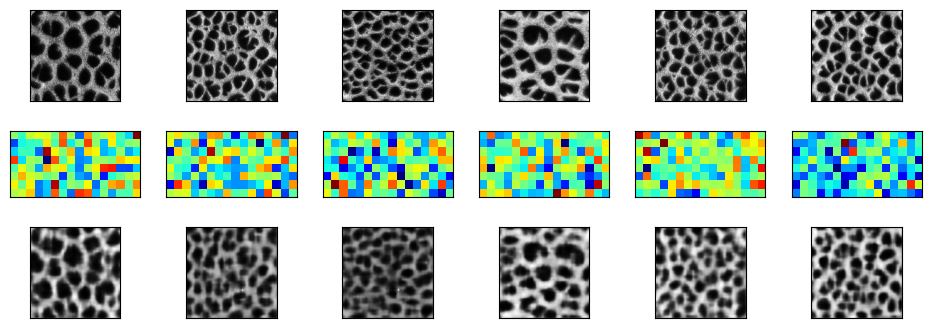

In [156]:
plt.figure(figsize=(40, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data_train[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoder_embds[1][i].reshape(dmy,dmx),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

In [157]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs_test = decoder.predict(encoder_embds_test[D])
print(np.shape(autoencoder_imgs_test),np.shape(encoder_embds_test))

6/6 [==============================] - 0s 4ms/step
(184, 128, 128, 1) (3, 184, 128)


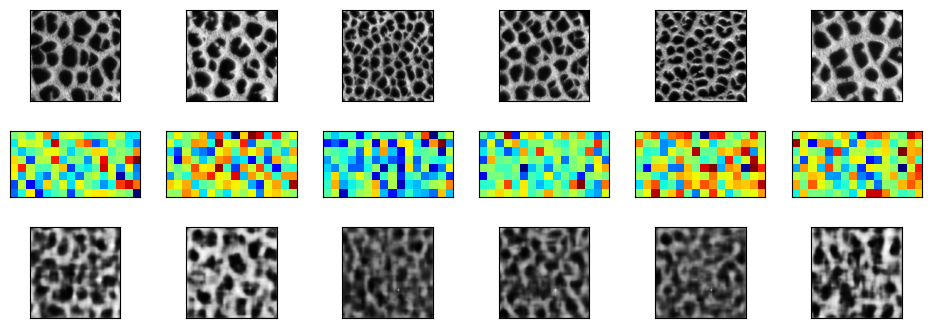

In [158]:
plt.figure(figsize=(40, 4))
for i in range(6):
    # display original
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(data_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    # display encoded image
    ax = plt.subplot(3, 20, i + 1 + 20)
    plt.imshow(encoder_embds_test[1][i].reshape(dmy,dmx),cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

## Visualización

### PCA - Training

In [23]:
pca_data = PCA(n_components=2)
PCA_2dim = pca_data.fit_transform(encoder_embds[D])
PCA_2dim.shape

(2990, 2)

In [24]:
labels_text = pd.DataFrame(label_train).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text.shape

(2990, 1)

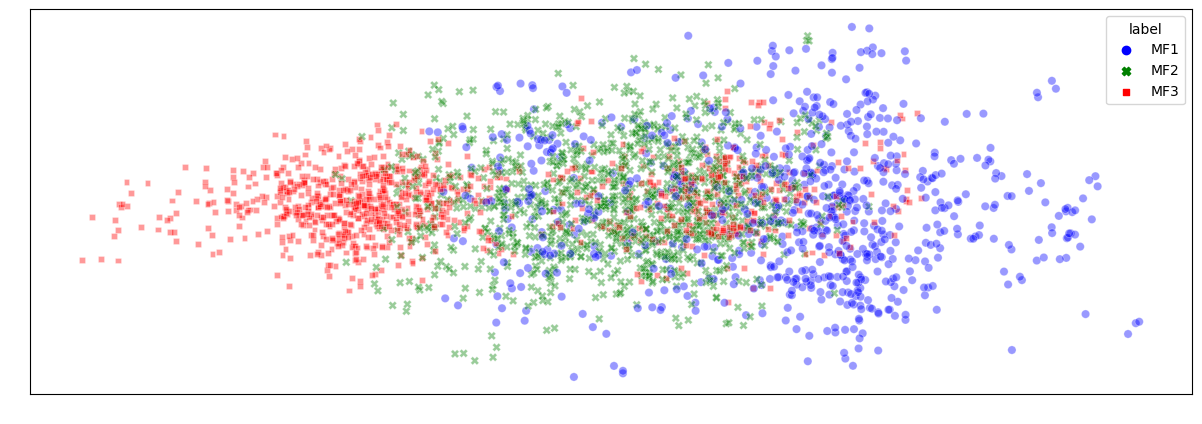

In [25]:
data_img = pd.DataFrame()                 
data_img['x'] = PCA_2dim[:,0]
data_img['y'] = PCA_2dim[:,1]
data_img['label'] = pd.DataFrame(labels_text)


plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img.x,y=data_img.y,hue='label',data=data_img, style='label',
            sizes=(60, 100), alpha=0.4, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks([])
plt.yticks([])
#plt.legend(fontsize="18")
#plt.xticks(range(-5, 5))
#plt.grid()

plt.show()

### PCA - Testing

In [26]:
labels_text_test = pd.DataFrame(np.argmax(label_test,axis=1)).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text_test.shape

(184, 1)

In [27]:
pca_data_test = PCA(n_components=2)
PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test[D])
PCA_2dim_test.shape

(184, 2)

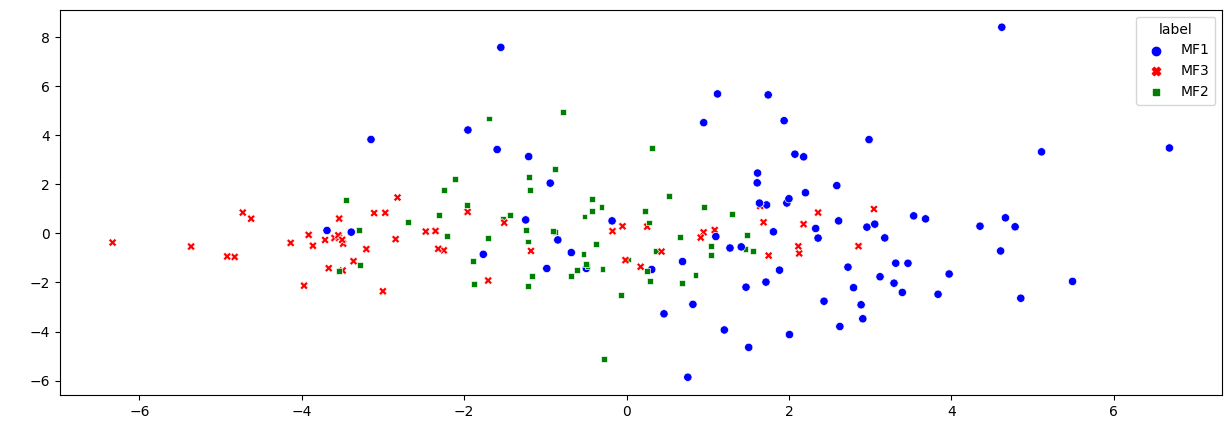

In [28]:
data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,style='label',
            sizes=(60, 100), alpha=1, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()

## Clasificación

In [29]:
char_to_num_new = {'MF1':0,'MF2':1,'MF3':2}
char_to_num_new

{'MF1': 0, 'MF2': 1, 'MF3': 2}

In [30]:
## Embebidos
#--- Train
media_train = encoder_embds[0]
variance_train = encoder_embds[1]
z_train = encoder_embds[2]

#--- Test
media_test = encoder_embds_test[0]
variance_test = encoder_embds_test[1]
z_test = encoder_embds_test[2]

#--- labels
#labels_text_test
#labels_text
#images_df['label'].replace(char_to_num,inplace=True)

data_embs_train = pd.DataFrame()
data_embs_train ['mean'] =  media_train.tolist()
data_embs_train ['var'] =  variance_train.tolist()
data_embs_train ['z'] =  z_train.tolist()
data_embs_train ['labels'] = labels_text[0].replace(char_to_num_new)

data_embs_test = pd.DataFrame()
data_embs_test ['mean'] =  media_test.tolist()
data_embs_test ['var'] =  variance_test.tolist()
data_embs_test ['z'] =  z_test.tolist()
data_embs_test ['labels'] = labels_text_test[0].replace(char_to_num_new)

In [31]:
data_embs_test

,mean,var,z,labels
0,"[-0.16282618045806885, 1.3182294368743896, -0....","[-3.261648178100586, -3.2010207176208496, -3.3...","[-0.21178483963012695, 1.3045040369033813, -0....",0
1,"[0.8590672016143799, 2.0803933143615723, -1.26...","[-3.6329987049102783, -3.465353488922119, -3.5...","[1.0351884365081787, 1.9820945262908936, -1.37...",0
2,"[-0.1303882896900177, 1.0451780557632446, 1.29...","[-3.5070979595184326, -3.59230375289917, -3.53...","[-0.09633257985115051, 0.9591289162635803, 1.3...",2
3,"[-0.18004025518894196, -0.013139801099896431, ...","[-3.4261465072631836, -3.5677437782287598, -3....","[-0.29761192202568054, 0.14981701970100403, 1....",1
4,"[1.465328574180603, 0.9439447522163391, 0.5655...","[-3.670036554336548, -3.52129864692688, -3.425...","[1.3412526845932007, 0.8513340950012207, 0.733...",2
...,...,...,...,...
179,"[0.3652634620666504, 0.8145784139633179, 0.357...","[-3.2936882972717285, -3.6363656520843506, -3....","[0.43001845479011536, 1.0130114555358887, 0.44...",1
180,"[0.41943153738975525, -2.0036509037017822, -1....","[-3.8533661365509033, -3.657529592514038, -3.8...","[0.4637705087661743, -2.0493266582489014, -1.2...",0
181,"[-0.8211857676506042, 1.1962943077087402, 0.21...","[-3.7373321056365967, -3.5917844772338867, -3....","[-0.9105381369590759, 1.0811342000961304, 0.39...",1
182,"[0.5031989216804504, 0.25175219774246216, 1.27...","[-3.5564043521881104, -3.5446393489837646, -3....","[0.7614419460296631, 0.2235317975282669, 1.311...",2


### DECISICION TREES

#### Media

max:  0.5321637426900584
accuracy 0.523 (+/- 0.12039)


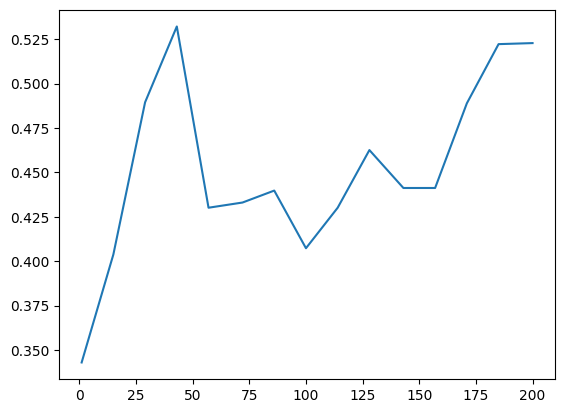

In [114]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *

dpst = []
acs = []

for d in np.linspace(1,200,15, dtype=int):
    est_DT_mean = DecisionTreeClassifier(max_depth=d,random_state=42)

    s = cross_val_score(est_DT_mean, list(data_embs_test['mean'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

In [115]:
from sklearn.metrics import classification_report

ML_model = est_DT_mean

ML_model.fit(list(data_embs_train['mean'].values),list(data_embs_train['labels']))

y_true_train = list(data_embs_train['labels'])
              
y_pred_train = ML_model.predict(list(data_embs_train['mean'].values))

print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       1.00      1.00      1.00      1160
           2       1.00      1.00      1.00      1055

    accuracy                           1.00      2990
   macro avg       1.00      1.00      1.00      2990
weighted avg       1.00      1.00      1.00      2990



In [116]:
from sklearn.metrics import classification_report

ML_model = est_DT_mean

ML_model.fit(list(data_embs_train['mean'].values),list(data_embs_train['labels']))

y_true_test = list(data_embs_test['labels'])
              
y_pred_test = ML_model.predict(list(data_embs_test['mean'].values))

print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.56      0.48      0.52        75
           1       0.38      0.44      0.41        57
           2       0.57      0.60      0.58        52

    accuracy                           0.50       184
   macro avg       0.51      0.50      0.50       184
weighted avg       0.51      0.50      0.50       184



In [117]:
## Salvar
np.save('results/embebidos/ML_classifiers/DT/mean/ytrue_train',y_true_train)
np.save('results/embebidos/ML_classifiers/DT/mean/ypredict_train',y_pred_train)
np.save('results/embebidos/ML_classifiers/DT/mean/ytrue_test',y_true_test)
np.save('results/embebidos/ML_classifiers/DT/mean/ypredict_test',y_pred_test)

#### Varianza

max:  0.5002923976608187
accuracy 0.346 (+/- 0.11774)


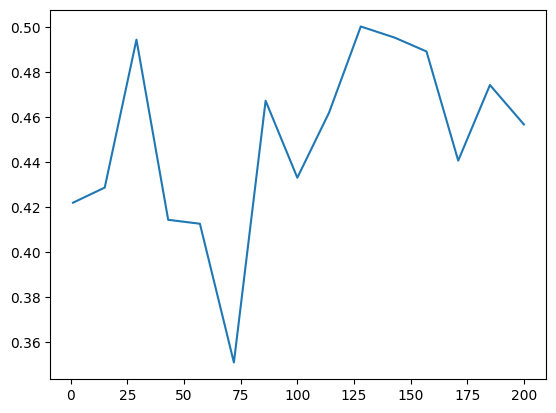

In [118]:
dpst = []
acs = []

for d in np.linspace(1,200,15, dtype=int):
    est_DT_var = DecisionTreeClassifier(max_depth=d,random_state=42)

    s = cross_val_score(est_DT_var, list(data_embs_test['var'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    
s = cross_val_score(est_DT_var, list(data_embs_test['var'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

In [119]:
from sklearn.metrics import classification_report

ML_model = est_DT_var

ML_model.fit(list(data_embs_train['var'].values),list(data_embs_train['labels']))

y_true_train = list(data_embs_train['labels'])
              
y_pred_train = ML_model.predict(list(data_embs_train['var'].values))

print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       1.00      1.00      1.00      1160
           2       1.00      1.00      1.00      1055

    accuracy                           1.00      2990
   macro avg       1.00      1.00      1.00      2990
weighted avg       1.00      1.00      1.00      2990



In [120]:
from sklearn.metrics import classification_report

ML_model = est_DT_var

ML_model.fit(list(data_embs_train['var'].values),list(data_embs_train['labels']))

y_true_test = list(data_embs_test['labels'])
              
y_pred_test = ML_model.predict(list(data_embs_test['var'].values))

print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.49      0.51      0.50        75
           1       0.34      0.39      0.36        57
           2       0.48      0.38      0.43        52

    accuracy                           0.43       184
   macro avg       0.44      0.43      0.43       184
weighted avg       0.44      0.43      0.44       184



In [121]:
## Salvar
np.save('results/embebidos/ML_classifiers/DT/var/ytrue_train',y_true_train)
np.save('results/embebidos/ML_classifiers/DT/var/ypredict_train',y_pred_train)
np.save('results/embebidos/ML_classifiers/DT/var/ytrue_test',y_true_test)
np.save('results/embebidos/ML_classifiers/DT/var/ypredict_test',y_pred_test)

#### Z

max:  0.5105263157894737
accuracy 0.424 (+/- 0.14381)


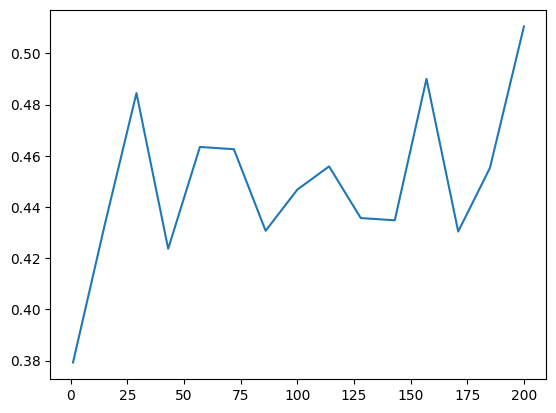

In [122]:
dpst = []
acs = []

for d in np.linspace(1,200,15, dtype=int):
    est_DT_z = DecisionTreeClassifier(max_depth=d,random_state=42)

    s = cross_val_score(est_DT_z, list(data_embs_test['z'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    

s = cross_val_score(est_DT_z, list(data_embs_test['z'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

In [123]:
from sklearn.metrics import classification_report

ML_model = est_DT_z

ML_model.fit(list(data_embs_train['z'].values),list(data_embs_train['labels']))

y_true_train = list(data_embs_train['labels'])
              
y_pred_train = ML_model.predict(list(data_embs_train['z'].values))

print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       1.00      1.00      1.00      1160
           2       1.00      1.00      1.00      1055

    accuracy                           1.00      2990
   macro avg       1.00      1.00      1.00      2990
weighted avg       1.00      1.00      1.00      2990



In [124]:
from sklearn.metrics import classification_report

ML_model = est_DT_z

ML_model.fit(list(data_embs_train['z'].values),list(data_embs_train['labels']))

y_true_test = list(data_embs_test['labels'])
              
y_pred_test = ML_model.predict(list(data_embs_test['z'].values))

print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.43      0.52        75
           1       0.39      0.56      0.46        57
           2       0.57      0.58      0.57        52

    accuracy                           0.51       184
   macro avg       0.54      0.52      0.52       184
weighted avg       0.55      0.51      0.52       184



In [125]:
## Salvar
np.save('results/embebidos/ML_classifiers/DT/z/ytrue_train',y_true_train)
np.save('results/embebidos/ML_classifiers/DT/z/ypredict_train',y_pred_train)
np.save('results/embebidos/ML_classifiers/DT/z/ytrue_test',y_true_test)
np.save('results/embebidos/ML_classifiers/DT/z/ypredict_test',y_pred_test)

### RANDOM FOREST

#### Media

max:  0.6640350877192983
accuracy 0.664 (+/- 0.10571)


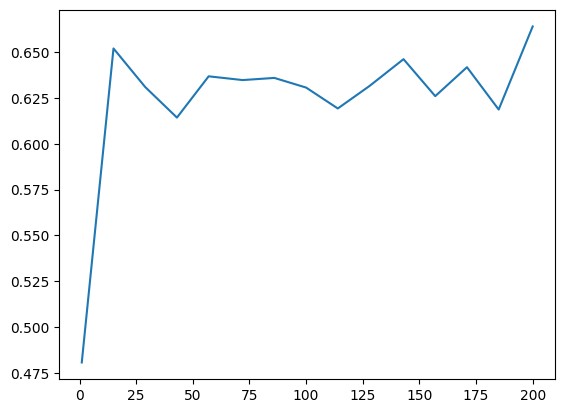

In [130]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


acs = []
dpst = []

for d in np.linspace(1,200,15, dtype=int):
    est_RF_mean = RandomForestClassifier(max_depth=d,random_state=42)

    s = cross_val_score(est_RF_mean, list(data_embs_test['mean'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()


In [131]:
from sklearn.metrics import classification_report

ML_model = est_RF_mean

ML_model.fit(list(data_embs_train['mean'].values),list(data_embs_train['labels']))

y_true_train = list(data_embs_train['labels'])
              
y_pred_train = ML_model.predict(list(data_embs_train['mean'].values))

print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       1.00      1.00      1.00      1160
           2       1.00      1.00      1.00      1055

    accuracy                           1.00      2990
   macro avg       1.00      1.00      1.00      2990
weighted avg       1.00      1.00      1.00      2990



In [132]:
from sklearn.metrics import classification_report

ML_model = est_RF_mean

ML_model.fit(list(data_embs_train['mean'].values),list(data_embs_train['labels']))

y_true_test = list(data_embs_test['labels'])
              
y_pred_test = ML_model.predict(list(data_embs_test['mean'].values))

print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.91      0.57      0.70        75
           1       0.54      0.86      0.66        57
           2       0.87      0.77      0.82        52

    accuracy                           0.72       184
   macro avg       0.77      0.73      0.73       184
weighted avg       0.79      0.72      0.72       184



In [133]:
## Salvar
np.save('results/embebidos/ML_classifiers/RF/mean/ytrue_train',y_true_train)
np.save('results/embebidos/ML_classifiers/RF/mean/ypredict_train',y_pred_train)
np.save('results/embebidos/ML_classifiers/RF/mean/ytrue_test',y_true_test)
np.save('results/embebidos/ML_classifiers/RF/mean/ypredict_test',y_pred_test)

#### Varianza

max:  0.5646198830409357
accuracy 0.505 (+/- 0.12667)


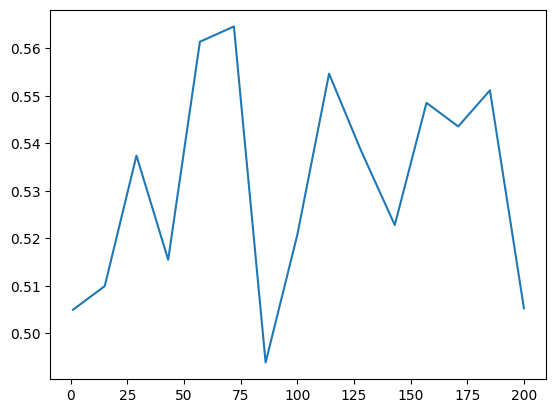

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

acs = []
dpst = []

for d in np.linspace(1,200,15, dtype=int):
    est_RF_var = RandomForestClassifier(max_depth=d,random_state=42)

    s = cross_val_score(est_RF_var, list(data_embs_test['var'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)
    
print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

In [135]:
from sklearn.metrics import classification_report

ML_model = est_RF_var

ML_model.fit(list(data_embs_train['var'].values),list(data_embs_train['labels']))

y_true_train = list(data_embs_train['labels'])
              
y_pred_train = ML_model.predict(list(data_embs_train['var'].values))

print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       1.00      1.00      1.00      1160
           2       1.00      1.00      1.00      1055

    accuracy                           1.00      2990
   macro avg       1.00      1.00      1.00      2990
weighted avg       1.00      1.00      1.00      2990



In [136]:
from sklearn.metrics import classification_report

ML_model = est_RF_var

ML_model.fit(list(data_embs_train['var'].values),list(data_embs_train['labels']))

y_true_test = list(data_embs_test['labels'])
              
y_pred_test = ML_model.predict(list(data_embs_test['var'].values))

print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.55      0.79      0.64        75
           1       0.44      0.42      0.43        57
           2       0.82      0.35      0.49        52

    accuracy                           0.55       184
   macro avg       0.60      0.52      0.52       184
weighted avg       0.59      0.55      0.53       184



In [137]:
## Salvar
np.save('results/embebidos/ML_classifiers/RF/var/ytrue_train',y_true_train)
np.save('results/embebidos/ML_classifiers/RF/var/ypredict_train',y_pred_train)
np.save('results/embebidos/ML_classifiers/RF/var/ytrue_test',y_true_test)
np.save('results/embebidos/ML_classifiers/RF/var/ypredict_test',y_pred_test)

#### Z

max:  0.6736842105263158
accuracy 0.674 (+/- 0.08991)


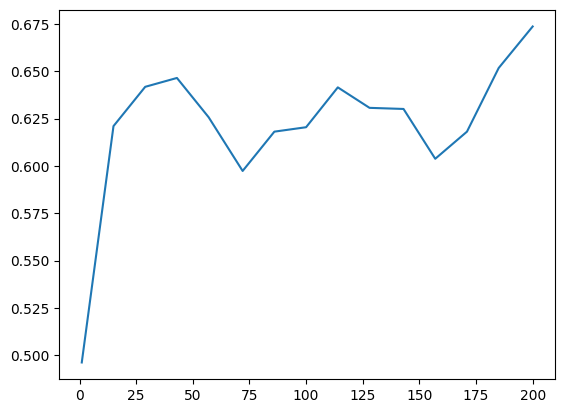

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

acs = []
dpst = []

for d in np.linspace(1,200,15, dtype=int):
    est_RF_z = RandomForestClassifier(max_depth=d,random_state=42)

    s = cross_val_score(est_RF_z, list(data_embs_test['z'].values),list(data_embs_test['labels'].values), cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
    acs.append(np.mean(s))
    dpst.append(d)   

print('max: ',np.max(acs))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
plt.plot(dpst,acs)

plt.show()

In [139]:
from sklearn.metrics import classification_report

ML_model = est_RF_z

ML_model.fit(list(data_embs_train['z'].values),list(data_embs_train['labels']))

y_true_train = list(data_embs_train['labels'])
              
y_pred_train = ML_model.predict(list(data_embs_train['z'].values))

print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       775
           1       1.00      1.00      1.00      1160
           2       1.00      1.00      1.00      1055

    accuracy                           1.00      2990
   macro avg       1.00      1.00      1.00      2990
weighted avg       1.00      1.00      1.00      2990



In [140]:
from sklearn.metrics import classification_report

ML_model = est_RF_z

ML_model.fit(list(data_embs_train['z'].values),list(data_embs_train['labels']))

y_true_test = list(data_embs_test['labels'])
              
y_pred_test = ML_model.predict(list(data_embs_test['z'].values))

print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.52      0.64        75
           1       0.52      0.79      0.62        57
           2       0.84      0.83      0.83        52

    accuracy                           0.69       184
   macro avg       0.74      0.71      0.70       184
weighted avg       0.74      0.69      0.69       184



In [141]:
## Salvar
np.save('results/embebidos/ML_classifiers/RF/z/ytrue_train',y_true_train)
np.save('results/embebidos/ML_classifiers/RF/z/ypredict_train',y_pred_train)
np.save('results/embebidos/ML_classifiers/RF/z/ytrue_test',y_true_test)
np.save('results/embebidos/ML_classifiers/RF/z/ypredict_test',y_pred_test)

### KNN

#### Media

29.347826086956523


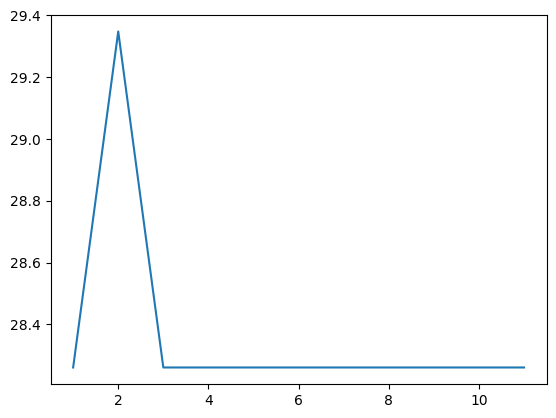

In [172]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scs = []
dst = []

for d in np.linspace(1,11,10, dtype=int):
    knn_mean = KNeighborsClassifier(n_neighbors = d)

    knn_mean.fit(list(data_embs_train['mean'].values),list(data_embs_train['labels'].values))

    y_pred = knn_mean.predict(list(data_embs_test['mean'].values))

    #print("Accuracy: ", accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    scs.append(accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    dst.append(d)

print(np.max(scs))
plt.plot(dst,scs)    

In [177]:
from sklearn.metrics import classification_report

embs = 'mean'

ML_model = KNeighborsClassifier(n_neighbors = 2)

ML_model.fit(list(data_embs_train[embs].values),list(data_embs_train['labels']))

y_pred_train = knn_mean.predict(list(data_embs_train[embs].values))

y_true_train = list(data_embs_train['labels'])
              
print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.00      0.01       775
           1       0.00      0.00      0.00      1160
           2       0.35      1.00      0.52      1055

    accuracy                           0.35      2990
   macro avg       0.45      0.33      0.18      2990
weighted avg       0.38      0.35      0.19      2990



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [178]:
from sklearn.metrics import classification_report

embs = 'mean'

ML_model = KNeighborsClassifier(n_neighbors = 2)

ML_model.fit(list(data_embs_train[embs].values),list(data_embs_train['labels']))

y_pred_test = knn_mean.predict(list(data_embs_test[embs].values))

y_true_test = list(data_embs_test['labels'])
              
print(classification_report(y_true_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.00      0.00      0.00        57
           2       0.28      1.00      0.44        52

    accuracy                           0.28       184
   macro avg       0.09      0.33      0.15       184
weighted avg       0.08      0.28      0.12       184



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Varianza

51.63043478260869
17


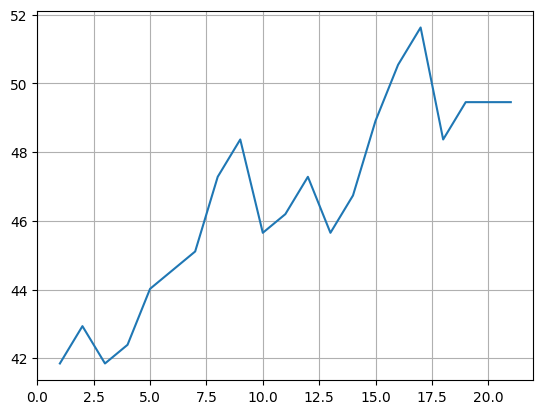

In [182]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scs = []
dst = []

for d in np.linspace(1,21,20, dtype=int):
    knn = KNeighborsClassifier(n_neighbors = d)

    knn.fit(list(data_embs_train['var'].values),list(data_embs_train['labels'].values))

    y_pred = knn.predict(list(data_embs_test['var'].values))

    #print("Accuracy: ", accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    scs.append(accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    dst.append(d)

print(np.max(scs))
print(dst[np.argmax(scs)])
plt.plot(dst,scs)   
plt.grid()

In [184]:
from sklearn.metrics import classification_report

embs = 'var'

ML_model = KNeighborsClassifier(n_neighbors = 2)

ML_model.fit(list(data_embs_train[embs].values),list(data_embs_train['labels']))

y_pred_train = knn_mean.predict(list(data_embs_train[embs].values))

y_true_train = list(data_embs_train['labels'])
              
print(classification_report(y_true_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.34      0.03      0.05       775
           1       0.39      0.98      0.55      1160
           2       0.00      0.00      0.00      1055

    accuracy                           0.39      2990
   macro avg       0.24      0.34      0.20      2990
weighted avg       0.24      0.39      0.23      2990



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Z

28.804347826086957


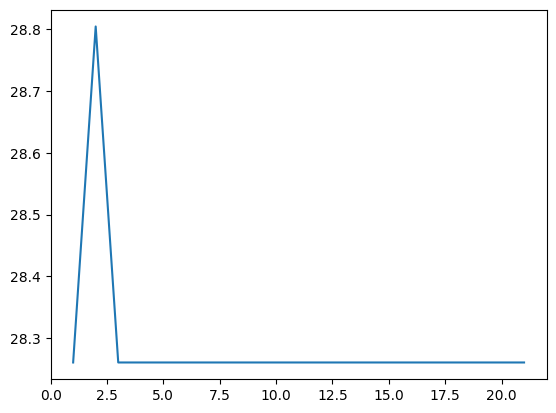

In [186]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

scs = []
dst = []

for d in np.linspace(1,21,20, dtype=int):
    knn = KNeighborsClassifier(n_neighbors = d)

    knn.fit(list(data_embs_train['z'].values),list(data_embs_train['labels'].values))

    y_pred = knn.predict(list(data_embs_test['z'].values))

    #print("Accuracy: ", accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    scs.append(accuracy_score(list(data_embs_test['labels'].values), y_pred)*100)
    dst.append(d)

print(np.max(scs))
plt.plot(dst,scs)  

## Exportar images

In [190]:
### guardar conjuntos de imágenes
np.save('results/embebidos/Images/img_test',X_test_secas)
np.save('results/embebidos/Images/img_train_1',X_train_secas_expanded[:1000])
np.save('results/embebidos/Images/img_train_2',X_train_secas_expanded[1000:2000])
np.save('results/embebidos/Images/img_train_3',X_train_secas_expanded[2000:])
## labels 
np.save('results/embebidos/Images/img_train_labels',data_embs_train['labels'].values)
np.save('results/embebidos/Images/img_test_labels',data_embs_test['labels'].values)

### Gaussian Variational Autoencoder

#### Train

In [41]:
## Dataframe
embs_training = pd.DataFrame()
embs_training['embedding_mean'] =list(encoder_embds[0])
embs_training['embedding_logvar'] = list(encoder_embds[1])
embs_training['embedding_z'] = list(encoder_embds[2])

In [42]:
### Diferencias con kullback-leibler
errors_training = []
for i in range(len(embs_training)):
    z_log_var = embs_training.iloc[i].embedding_logvar
    z_mean = embs_training.iloc[i].embedding_mean	
    error = 0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    errors_training.append(np.mean(error.numpy()))
    
np.shape(errors_training)

(2990,)

In [44]:
embs_training['KL_loss'] = errors_training
embs_training['label'] = labels_text
embs_training

,embedding_mean,embedding_logvar,embedding_z,KL_loss,label
0,"[1.1040497, 1.2641147, -1.7853262, -0.26537746...","[-3.4180212, -3.4897158, -3.367004, -3.3349156...","[0.8847492, 1.1579369, -1.7538034, -0.52864045...",-1.816243,MF1
1,"[0.7201699, -1.1492598, 0.7465677, -0.9982958,...","[-3.8075643, -3.760372, -3.8423326, -3.8594031...","[0.44673303, -0.7505907, 0.5922076, -1.2227651...",-1.994459,MF2
2,"[0.24430117, 0.6978565, 1.7615497, -0.12031991...","[-3.907947, -3.753066, -3.827178, -3.660748, -...","[0.30644655, 0.98937804, 1.84974, -0.41305, 0....",-1.883868,MF3
3,"[-2.518783, 0.06545785, 1.5845945, 0.04860364,...","[-4.0408435, -3.595418, -4.100499, -4.0535946,...","[-2.5617285, 0.052398168, 1.6593808, 0.1464058...",-2.346756,MF1
4,"[1.6217899, -0.035400365, 1.6334059, 0.6240760...","[-3.5649567, -3.713633, -4.2294765, -3.9720314...","[1.5845462, -0.31958666, 1.5561485, 0.8764918,...",-2.001742,MF2
...,...,...,...,...,...
2985,"[0.90608615, 0.6514577, -2.9232502, 2.4601572,...","[-3.999551, -3.7413702, -3.9116957, -3.9760978...","[0.9902431, 0.61597383, -2.6114612, 2.522344, ...",-2.029372,MF2
2986,"[-0.10864907, 0.05779003, -0.6466596, -0.25460...","[-4.0988884, -3.6948438, -4.0377145, -4.128120...","[-0.24540046, 0.06856073, -0.37468123, 0.02382...",-1.816064,MF3
2987,"[-0.17902863, -0.6487853, 0.47204384, 1.005422...","[-4.186496, -4.151249, -4.144353, -4.365615, -...","[-0.13946329, -0.69264305, 0.35375643, 0.99847...",-2.012282,MF3
2988,"[0.0568908, -1.3055112, 0.34557253, 0.00258672...","[-3.796528, -3.6510081, -3.8137145, -3.6616354...","[0.085702896, -1.2882718, 0.22213528, 0.298060...",-1.641188,MF3


In [48]:
embs_logvar_training = embs_training.embedding_logvar.values.tolist()
embs_mean_trainig = embs_training.embedding_mean.values.tolist()
embs_z_trainig = embs_training.embedding_z.values.tolist()
labels_training = embs_training.label.values.tolist()
errors_training = embs_training.KL_loss.values.tolist()

np.save('results/embebidos/embs_logvar_training',embs_logvar_training)
np.save('results/embebidos/embs_mean_training',embs_mean_trainig)
np.save('results/embebidos/embs_z_training',embs_z_trainig)
np.save('results/embebidos/label_training',labels_training)
np.save('results/embebidos/kl_loss_training',errors_training) 

In [51]:
### Embebidos test
encoder_embds_Test  = encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_Test))

6/6 [==============================] - 0s 22ms/step
Shape_embs:  (3, 184, 128)


In [52]:
embs_test = pd.DataFrame()
embs_test['embedding_mean'] =list(encoder_embds_Test[0])
embs_test['embedding_logvar'] = list(encoder_embds_Test[1])
embs_test['embedding_z'] = list(encoder_embds_Test[2])

In [53]:
### Diferencias con kullback-leibler
errors_test = []
for i in range(len(embs_test)):
    z_log_var = embs_test.iloc[i].embedding_logvar
    z_mean = embs_test.iloc[i].embedding_mean	
    error = 0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    errors_test.append(np.mean(error.numpy()))
    
np.shape(errors_test)

(184,)

In [55]:
embs_test['KL_loss'] = errors_test
embs_test['label'] = labels_text_test

embs_test

,embedding_mean,embedding_logvar,embedding_z,KL_loss,label
0,"[-0.16282618, 1.3182294, -0.15468852, -1.99688...","[-3.2616482, -3.2010207, -3.306845, -3.1652637...","[-0.024702296, 1.6856818, 0.0025335997, -1.749...",-1.666973,MF1
1,"[0.8590672, 2.0803933, -1.2623978, 0.30301303,...","[-3.6329987, -3.4653535, -3.5955644, -3.534059...","[0.80200225, 2.1237333, -1.2475932, 0.2858721,...",-2.018898,MF1
2,"[-0.13038829, 1.045178, 1.2977952, -0.02872528...","[-3.507098, -3.5923038, -3.5312576, -3.525671,...","[-0.214754, 0.97992903, 1.0045152, -0.01137936...",-1.544982,MF3
3,"[-0.18004026, -0.013139801, 1.9752624, 0.76403...","[-3.4261465, -3.5677438, -3.365775, -2.9843044...","[0.069947556, 0.12008236, 2.0101411, 0.7444194...",-1.696936,MF2
4,"[1.4653286, 0.94394475, 0.5655084, -1.1251347,...","[-3.6700366, -3.5212986, -3.4251509, -3.824235...","[1.4426829, 1.0779064, 0.31175178, -0.86775583...",-1.609507,MF3
...,...,...,...,...,...
179,"[0.36526346, 0.8145784, 0.3574501, 0.16873631,...","[-3.2936883, -3.6363657, -3.5069966, -3.550330...","[0.42278764, 0.8385194, 0.34166616, 0.5061666,...",-1.726784,MF2
180,"[0.41943154, -2.003651, -1.4218875, 0.67814213...","[-3.8533661, -3.6575296, -3.8196566, -3.451863...","[0.44124123, -2.1186552, -1.6941649, 0.6911588...",-2.058094,MF1
181,"[-0.82118577, 1.1962943, 0.2186241, 1.0335876,...","[-3.737332, -3.5917845, -3.6148105, -4.020273,...","[-0.8770141, 1.247902, 0.44475287, 1.2581942, ...",-1.981061,MF2
182,"[0.5031989, 0.2517522, 1.2797735, -0.5367353, ...","[-3.5564044, -3.5446393, -3.6636167, -3.605945...","[0.45245045, 0.51217526, 1.2497023, -0.5825934...",-1.558675,MF3


In [56]:
embs_logvar_test = embs_test.embedding_logvar.values.tolist()
embs_mean_trainig = embs_test.embedding_mean.values.tolist()
embs_z_trainig = embs_test.embedding_z.values.tolist()
labels_test = embs_test.label.values.tolist()
errors_test = embs_test.KL_loss.values.tolist()

np.save('results/embebidos_confocales/embs_logvar/embs_logvar_test',embs_logvar_test)
np.save('results/embebidos_confocales/embs_mean/embs_mean_test',embs_mean_trainig)
np.save('results/embebidos_confocales/embs_z/embs_z_test',embs_z_trainig)
np.save('results/embebidos_confocales/label/label_test',labels_test)
np.save('results/embebidos_confocales/kl_loss/kl_loss_test',errors_test) 

In [57]:
### exportar dataframes as .csv
ruta_save = 'results/embebidos/'
embs_test.to_csv(ruta_save+'embs_test.csv', index=False)
embs_training.to_csv(ruta_save+'embs_training.csv', index=False)

In [61]:
### guardar conjuntos de imágenes
np.save('results/embebidos_confocales/img_test',X_test_secas)
np.save('results/embebidos_confocales/img_train_1',X_train_secas_expanded[:1000])
np.save('results/embebidos_confocales/img_train_2',X_train_secas_expanded[1000:2000])
np.save('results/embebidos_confocales/img_train_3',X_train_secas_expanded[2000:])